In [19]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [4]:
# build vocabulary of characters and encoder/decoder (tokenizer)
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(f'{itos=}')
print(f'{vocab_size=}')

itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab_size=27


In [5]:
# build dataset
block_size = 3        # context length

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:]+[ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])      # 0.8
Xdev, Ydev = build_dataset(words[n1:n2])  # 0.1
Xte, Yte = build_dataset(words[n2:])      # 0.1

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# Multilayer Perceptron
n_embed = 10      # dimensionality of character embedding vectors 
n_hidden = 200    # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print('number of parameters in the model', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

number of parameters in the model 11897


In [7]:
# hyper-parameters
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # (32,)
    Xb = Xtr[ix]      # (32, 3)
    Yb = Ytr[ix]      # (32)
    
    # forward pass
    emb = C[Xb]       # (32, 3, 10)
    embcat = emb.view(emb.shape[0], -1) # (32, 30)
    hpreact = embcat @ W1 + b1   # hidden layer pre-activation, (32, 200)
    h = torch.tanh(hpreact)      # hidden layer
    logits = h @ W2 + b2         # output
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # back prop
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
#     break

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


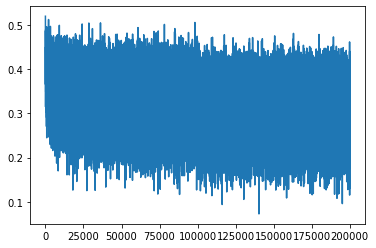

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad()      # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': {Xtr, Ytr},
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)   # (batch_size, n_hidden)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355825424194336
val 2.1026735305786133


#### Reasons for subpar training
* The initial weights are not properly set
* most of the neurons have grad = 0, hence can't be trained further

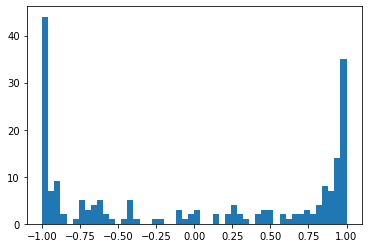

In [11]:
plt.hist(h.view(-1).tolist(), 50);

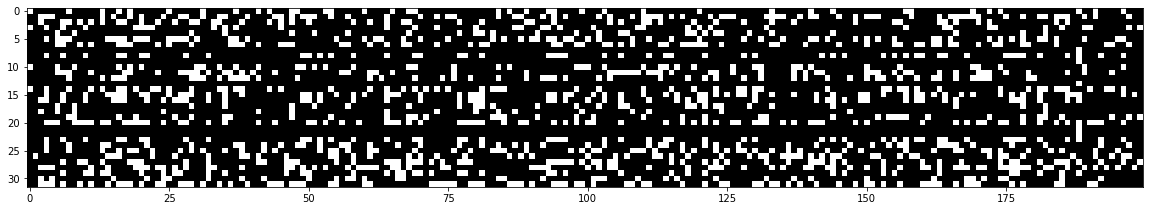

In [17]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.savefig('h before training, restricted random weights (2)')
plt.show()


In [13]:
h.shape

torch.Size([1, 200])

tensor(0.0118) tensor(1.0008)
tensor(-0.0037) tensor(3.1737)


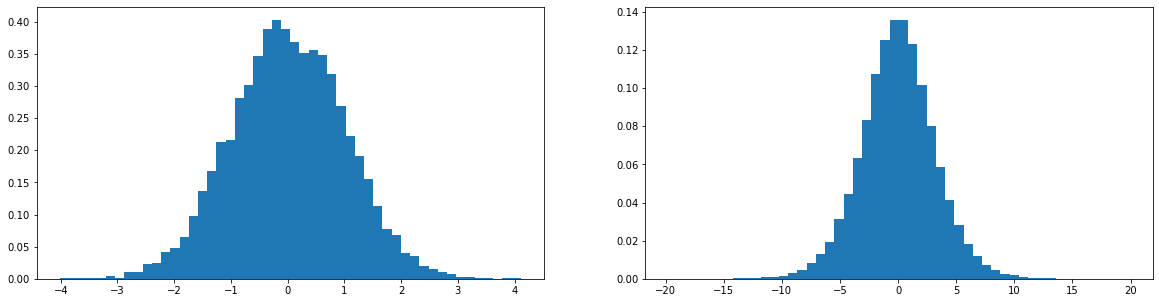

In [14]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [10]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    output = []
    context = [0] * block_size    # starting context
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, n_embed)
        embcat = emb.view(emb.shape[0], -1) # match dimensions with W1
        h = torch.tanh(embcat @ W1 + b1)   # hidden layer
        logits = h @ W2 + b2    # output
        probs = F.softmax(logits, dim=1)    # prob distribution
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window
        context = context[1:] + [ix]
        output.append(itos[ix])
        if ix == 0:
            break
            
    print(''.join(output))

dex.
mariah.
makilah.
tyhammonie.
traine.
kayk.
kata.
kreez.
pebutharminton.
moriella.
kinzleed.
akareedensedey.
niavion.
rosbur.
hunaven.
tahiro.
kaspe.
breen.
hayah.
isa.


### To combat the variance of pre-activation distribution
**Delving Deep into Rectifiers:** _Surpassing Human-Level Performance on ImageNet Classification


    1. $x, \ w ~ N(0, 1)$       2. $channel size$: 10 \
$$y = x @ w$$
**To maintain std(y) ~ 1:** 
$$y = \frac{5/3}{\sqrt{channel \ size}} x @ w \ \ \ \ \ \ \ \ \ \ \ \ \ \text{tanh activation}$$
$$y = \frac{2}{\sqrt{channel \ size}} x @ w \ \ \ \ \ \ \ \ \ \ \ \ \ \text{ReLU activation}$$

Or just do **torch.nn.inti.kaiming_normal_(tensor, a=0, mode='fain_in', nonlinearity='leaky_relu')**


## Batch Normalization
Sergey Ioffe, Christian Szegedy - Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift \
**The main idea is that we can just normalize the pre-activation states and it just works**

We don't have to manually tune these parameters while setting up initial weights. This is primarily because:
* torch.nn.init.kaiming_normal_
* Batch Normalization
* Adam Optimizer

In [21]:
# Multilayer Perceptron
n_embed = 10      # dimensionality of character embedding vectors 
n_hidden = 200    # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / ((n_embed * block_size)**0.5)
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print('number of parameters in the model', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

number of parameters in the model 12297


In [22]:
# hyper-parameters
max_steps = 200000
batch_size = 32
lossi = []

start = time.time()
for i in range(max_steps):
    
    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # (32,)
    Xb = Xtr[ix]      # (32, 3)
    Yb = Ytr[ix]      # (32)
    
    # forward pass
    emb = C[Xb]       # (32, 3, 10)
    embcat = emb.view(emb.shape[0], -1) # (32, 30)
    hpreact = embcat @ W1 + b1   # hidden layer pre-activation, (32, 200)
    
    # batch normalization
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    
    h = torch.tanh(hpreact)      # hidden layer
    logits = h @ W2 + b2         # output
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # back prop
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
#     break

end = time.time()
print(f'time for training: {(end-start)/1000}s')

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347
time for training: 0.7391704370975495s


## Problem with making predictions
Now since we are using batch normalization, how are we going to make predictions?

Batch normalization expects a batch of inputs to calculate batch mean and variance to recallibrate the pre-activations. \
Works around is to calculate the mean & variance for the entire training dataset at the start and use them instead.

In [24]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean & std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [25]:
@torch.no_grad()      # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': {Xtr, Ytr},
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # new step 
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)   # (batch_size, n_hidden)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066781759262085
val 2.1049118041992188


### Calculate Running Mean / Std
Modify code so the mean / std could be calculated during training itself

In [39]:
# Multilayer Perceptron
n_embed = 10      # dimensionality of character embedding vectors 
n_hidden = 200    # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / ((n_embed * block_size)**0.5)
# b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print('number of parameters in the model', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

number of parameters in the model 12097


In [40]:
# hyper-parameters
max_steps = 200000
batch_size = 32
lossi = []

start = time.time()
for i in range(max_steps):
    
    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # (32,)
    Xb = Xtr[ix]      # (32, 3)
    Yb = Ytr[ix]      # (32)
    
    # forward pass
    emb = C[Xb]       # (32, 3, 10) embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) # (32, 30) concat the vectors
    # Linear layer
    hpreact = embcat @ W1 # + b1   # hidden layer pre-activation, (32, 200)
    
    # batch normalization
    # -----------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -----------------------------------------------------------------
    
    # Non-linearity
    h = torch.tanh(hpreact)      # hidden layer
    logits = h @ W2 + b2         # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # back prop
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
#     break

end = time.time()
print(f'time for training: {(end-start)/60} mins')

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0198
 190000/ 200000: 2.1707
time for training: 4.861522881189982 mins


In [41]:
@torch.no_grad()      # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': {Xtr, Ytr},
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    # new step 
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)   # (batch_size, n_hidden)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0673418045043945
val 2.1056971549987793


### loss log

* original \
train 2.12
val 2.16

* fix softmax confidently wrong \
train 2.07
val 2.13

* fix tanh layer too saturated at init \
train 2.0355825424194336 \
val 2.1026735305786133

* batch normalization \
train 2.0378172397613525 \
val 2.1069703102111816

* batch normalization with running mean & std \
train 2.0673418045043945 \
val 2.1056971549987793


dont' want the pre-activations to be too small
    - since then tanh won't do much
don't want the pre-activations to be too large
    - since then tanh would be too saturated